In [1]:
import requests_cache
requests_cache.install_cache('cache', allowable_codes=[200, 404], allowable_methods=['GET', 'POST'])
import requests
import pandas as pd
from tqdm.auto import tqdm
import json
pd.set_option("display.max_columns", None)

price_history = pd.read_csv("price_history.csv")
price_history.sort_values(price_history.columns.tolist(), inplace=True)

all_products = []
new_prices = []
for page in tqdm(range(1, 84)):
    try:
        r = requests.get("https://www.woolworths.co.nz/api/v1/products", params={
            "target": "browse",
            "inStockProductsOnly": "false",
            "size": 120,
            "page": page
        }, headers={
            "x-requested-with": "??",
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/129.0.0.0 Safari/537.36 Edg/129.0.0.0"
        }, timeout=5)
        r.raise_for_status()
        timestamp = int(r.created_at.timestamp())
        products = r.json()["products"]["items"]
        assert len(products) > 0, "No products"
        for product in products:
            sku = int(product["sku"])
            prices = price_history[price_history.SKU == sku].price
            if len(prices) == 0:
                last_price = None
            else:
                last_price = prices.iloc[-1]
            if product["price"]["salePrice"] != last_price:
                print(f"SKU {sku} price changed from {last_price} to {product['price']['salePrice']}")
                new_prices.append({
                    "SKU": sku,
                    "timestamp": timestamp,
                    "price": product["price"]["salePrice"]
                })
        all_products.extend(products)
    except Exception as e:
        raise
df = pd.json_normalize(all_products)
df.to_csv("products.csv", index=False)
df

  0%|          | 0/83 [00:00<?, ?it/s]

SKU 309899 price changed from 6.0 to 8.5
SKU 840700 price changed from None to 6.5
SKU 171536 price changed from 9.95 to 8.9
SKU 115625 price changed from None to 6.5
SKU 22806 price changed from None to 8.0
SKU 805708 price changed from None to 2.5
SKU 115161 price changed from None to 3.9
SKU 165289 price changed from None to 10.99
SKU 198148 price changed from None to 3.4
SKU 810588 price changed from None to 3.5
SKU 13734 price changed from None to 15.0
SKU 919098 price changed from None to 5.0
SKU 282509 price changed from None to 7.99
SKU 114172 price changed from None to 3.49
SKU 156809 price changed from None to 3.49
SKU 476529 price changed from 6.69 to 6.59
SKU 685415 price changed from 15.99 to 8.99
SKU 911074 price changed from None to 5.9
SKU 286576 price changed from None to 5.8
SKU 140508 price changed from None to 7.5
SKU 266929 price changed from None to 5.8
SKU 165406 price changed from None to 4.99


,type,name,barcode,variety,brand,slug,sku,unit,selectedPurchasingUnit,stockLevel,eachUnitQuantity,averageWeightPerUnit,hasShopperNotes,productTag,departments,subsAllowed,supportsBothEachAndKgPricing,adId,brandSuggestionId,brandSuggestionName,priceUnitLabel,availabilityStatus,onlineSample,onlineSampleRealProductMapId,price.originalPrice,price.salePrice,price.savePrice,price.savePercentage,price.canShowSavings,price.hasBonusPoints,price.isClubPrice,price.isSpecial,price.isNew,price.canShowOriginalPrice,price.discount,price.total,price.isTargetedOffer,price.averagePricePerSingleUnit,price.isBoostOffer,price.purchasingUnitPrice,price.orderedPrice,price.isUsingOrderedPrice,price.currentPricingMatchesOrderedPricing,price.extendedListPrice,price.originalAveragePricePerSingleUnit,images.small,images.big,quantity.min,quantity.max,quantity.increment,quantity.value,quantity.quantityInOrder,quantity.purchasingQuantityString,size.cupListPrice,size.cupPrice,size.cupMeasure,size.packageType,size.volumeSize,productTag.tagType,productTag.multiBuy,productTag.bonusPoints,productTag.additionalTag.name,productTag.additionalTag.link,productTag.additionalTag.imagePath,productTag.additionalTag.linkTarget,productTag.additionalTag.altText,productTag.targetedOffer,productTag.boostOffer,productTag.additionalTag,productTag.multiBuy.quantity,productTag.multiBuy.value,productTag.multiBuy.link,productTag.multiBuy.multiCupValue
0,Product,fresh fruit bananas yellow,9354829000064,yellow,fresh fruit,fresh-fruit-bananas-yellow,133211,Kg,None,3,None,0.25,None,NaN,"[{'id': 1, 'name': 'Fruit & Veg'}]",False,True,None,None,None,None,In Stock,None,0,3.45,3.45,0.00,0.0,True,False,False,False,False,True,None,None,False,0.86,False,None,None,False,None,None,None,https://assets.woolworths.com.au/images/2010/1...,https://assets.woolworths.com.au/images/2010/1...,0.2,100.0,0.2,None,None,None,3.45,3.450000,1kg,loose,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Product,woolworths butter salted,9300633725082,salted,woolworths,woolworths-butter-salted,827847,Each,None,3,None,NaN,None,NaN,"[{'id': 4, 'name': 'Fridge & Deli'}]",False,False,None,None,None,None,In Stock,None,0,6.49,6.49,0.00,0.0,True,False,False,False,False,True,None,None,False,NaN,False,None,None,False,None,None,None,https://assets.woolworths.com.au/images/2010/8...,https://assets.woolworths.com.au/images/2010/8...,1.0,4.0,1.0,None,None,None,1.30,1.300000,100g,None,500g,Other,NaN,NaN,Countdown's Own,/shop/productgroup/80842,/Content/PromotionTags/F24_Own_brand.png,_self,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Product,fresh vegetable cucumbers telegraph,9421901390013,telegraph,fresh vegetable,fresh-vegetable-cucumbers-telegraph,281455,Each,None,3,None,NaN,None,NaN,"[{'id': 1, 'name': 'Fruit & Veg'}]",False,False,None,None,None,None,In Stock,None,0,2.20,2.20,0.00,0.0,True,False,False,False,False,True,None,None,False,NaN,False,None,None,False,None,None,None,https://assets.woolworths.com.au/images/2010/2...,https://assets.woolworths.com.au/images/2010/2...,1.0,100.0,1.0,None,None,None,3.19,2.200000,1ea,,,Other,NaN,NaN,Fresh Deals,Self,/Content/PromotionTags/F24_Fresh_deal.png,_self,Fresh Deals,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Product,woolworths milk standard,9414742036509,standard,woolworths,woolworths-milk-standard,282768,Each,None,3,None,NaN,None,NaN,"[{'id': 4, 'name': 'Fridge & Deli'}]",False,False,None,None,None,None,In Stock,None,0,6.18,6.18,0.00,0.0,True,False,False,False,False,True,None,None,False,NaN,False,None,None,False,None,None,None,https://assets.woolworths.com.au/images/2010/2...,https://assets.woolworths.com.au/images/2010/2...,1.0,100.0,1.0,None,None,None,2.06,2.060000,1L,bottle,3L,Other,NaN,NaN,Countdown's Own,/shop/productgroup/80842,/Content/PromotionTags/F24_Own_brand.png,_self,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Product,fresh vegetable broccoli head,9414742350858,head,fresh vegetable,fresh-vegetable-broccoli-head,281082,Each,None,3,None,NaN,None,NaN,"[{'id': 1, 'name': 'Fruit & Veg'}]

In [2]:
price_history = pd.concat([price_history, pd.DataFrame(new_prices)], ignore_index=True).sort_values(price_history.columns.tolist())
price_history

,SKU,timestamp,price
0,25,1728880327,3.99
1,168,1728880353,2.60
2,326,1728880348,4.30
3,579,1728880353,1.00
4,579,1729443688,2.00
...,...,...,...
33266,983433,1731258195,9.49
33267,991433,1728880355,10.80
33268,991433,1729443688,9.90
33269,991433,1730048476,10.80


In [3]:
price_history.groupby("SKU").size().value_counts()

1    3256
5    2950
3    1671
4    1163
2     791
6     452
7     172
8      11
9       4
dtype: int64

In [4]:
delta = price_history.groupby("SKU").price.diff()
delta.describe()

count    22823.000000
mean         0.010015
std          2.500650
min        -28.990000
25%         -1.000000
50%          0.040000
75%          1.050000
max         28.990000
Name: price, dtype: float64

<Axes: ylabel='Frequency'>

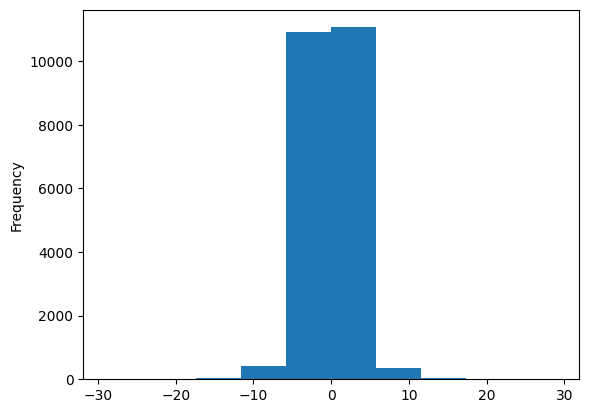

In [5]:
delta.plot.hist()

In [6]:
price_history.to_csv("price_history.csv", index=False)